# 0. Imports

In [2]:
from pipeline.load_activations import prepare_dataloaders
import torch
import torch.nn as nn
import gc
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from einops import einsum
from torch.utils.data import Dataset, DataLoader

In [3]:
def get_start_pos(token_ids: torch.Tensor) -> int:
    im_start_token = 151644
    im_start_positions = (token_ids == im_start_token).nonzero(as_tuple=True)[0]
    return im_start_positions[1].item()

## 1. Progress bar trajectories

In [ ]:
train_dataloader, test_dataloader, stats = prepare_dataloaders(
        activations_dir="/workspace/llm-progress-monitor/rollouts-big/activations",
        batch_size=1024,
        test_size=0.01,
        end_idx = 2000,
        shuffle = True
    )

### linear to predict linear

In [ ]:
all_acts = []
all_n_remaining = []

In [ ]:
for activations, n_remaining, n_total in train_dataloader:
    all_acts.append(activations.to('cuda', dtype=torch.float32))
    all_n_remaining.append(n_remaining.to('cuda', dtype=torch.float32))

all_acts = torch.cat(all_acts)
all_n_remaining = torch.cat(all_n_remaining)


In [ ]:
# Solve using normal equations: beta = (X^T X)^{-1} X^T y
XTX = all_acts.T @ all_acts
XTy = all_acts.T @ all_n_remaining
linear_to_linear_betas = torch.linalg.solve(XTX, XTy)

In [ ]:
linear_to_linear_betas.shape

In [ ]:
torch.save(linear_to_linear_betas, '/workspace/final_write_up/linear_to_linear_betas.pt')

### linear to predict log

In [ ]:
# Solve using normal equations: beta = (X^T X)^{-1} X^T y
XTX = all_acts.T @ all_acts
XTy = all_acts.T @ (all_n_remaining + 1).log()
linear_to_log_betas = torch.linalg.solve(XTX, XTy)
torch.save(linear_to_log_betas, '/workspace/final_write_up/linear_to_log_betas.pt')

In [ ]:
del all_acts, all_n_remaining, linear_to_linear_betas, linear_to_log_betas

gc.collect()
torch.cuda.empty_cache()

### bins classifier

In [ ]:
class LogBinClassifer(nn.Module):
    def __init__(self, input_dim: int, n_bins: int):
        super().__init__()
        self.n_bins = n_bins
        self.linear = nn.Linear(input_dim, n_bins)

    def forward(self, x):
        return self.linear(x)

In [7]:
n_bins = 11
def bin_y(y):
    return (y+1).log().floor().clamp(0,n_bins-1).to('cuda', dtype=torch.long)

In [ ]:
model = LogBinClassifer(2560, 10).to('cuda')
optimizer = Adam(model.parameters(), lr=1e-4)

In [ ]:
loss_fn = CrossEntropyLoss()

In [ ]:
n_epochs = 3
for epoch in range(n_epochs):
    for activations, n_remaining, n_total in train_dataloader:
        optimizer.zero_grad()
        pred = model(activations.to('cuda', dtype=torch.float32))
        n_remaining_binned = bin_y(n_remaining)
        loss = loss_fn(pred, n_remaining_binned)
        loss.backward()
        optimizer.step()
        print(loss.item())
        

In [ ]:
torch.save(model.state_dict(), '/workspace/llm-progress-monitor/final_write_up/log_bin_classifier.pt')

### using the randomly sampled from each sequence

In [ ]:
import random

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import threading

def load_and_sample_activations(i):
    token_ids, activations = torch.load(f'/workspace/llm-progress-monitor/rollouts-big/activations/{i}.pt')
    start_pos = get_start_pos(token_ids)
    activations = activations[:, start_pos:].to('cuda')
    token_ids = token_ids.to('cuda')

    n_remaining = activations.shape[-2] - torch.arange(activations.shape[-2], device=activations.device)
    # Randomly sample 200 indices from the sequence
    random_indices = random.sample(range(activations.shape[-2]), min(200, activations.shape[-2]))
    random_indices = torch.tensor(random_indices, device=activations.device)
    chosen_activations = activations[:,random_indices]
    chosen_n_remaining = n_remaining[random_indices]
    print(f'{i} done')
    return chosen_activations, chosen_n_remaining

all_chosen_activations = []
all_chosen_n_remaining = []

with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(executor.map(load_and_sample_activations, range(2000)))

for chosen_activations, chosen_n_remaining in results:
    all_chosen_activations.append(chosen_activations[0])
    all_chosen_n_remaining.append(chosen_n_remaining)

all_chosen_activations = torch.cat(all_chosen_activations)
all_chosen_n_remaining = torch.cat(all_chosen_n_remaining)



In [ ]:
all_chosen_activations = all_chosen_activations.to('cuda', dtype=torch.float32)
all_chosen_n_remaining = all_chosen_n_remaining.to('cuda', dtype=torch.float32)


In [ ]:
XtX = all_chosen_activations.T @ all_chosen_activations
XTy = all_chosen_activations.T @ all_chosen_n_remaining

lin_to_lin_betas = torch.linalg.solve(XtX, XTy)

In [ ]:
torch.save(lin_to_lin_betas, '/workspace/final_write_up/balanced_lin_to_lin_betas.pt')

In [ ]:
XTy = all_chosen_activations.T @ (all_chosen_n_remaining + 1).log()
lin_to_log_betas = torch.linalg.solve(XtX, XTy)
torch.save(lin_to_log_betas, '/workspace/final_write_up/balanced_lin_to_log_betas.pt')

In [ ]:
class BalancedDataset(Dataset):
    def __init__(self, all_chosen_activations, all_chosen_n_remaining):
        self.all_chosen_activations = all_chosen_activations
        self.all_chosen_n_remaining = all_chosen_n_remaining

    def __len__(self):
        return len(self.all_chosen_activations)
    
    def __getitem__(self, idx):
        return self.all_chosen_activations[idx], self.all_chosen_n_remaining[idx]
    
train_dataset = BalancedDataset(all_chosen_activations, all_chosen_n_remaining)
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
model = LogBinClassifer(2560, 10).to('cuda')

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-4)
loss_fn = CrossEntropyLoss()

In [ ]:
n_epochs = 1
for epoch in range(n_epochs):
    for activations, n_remaining in train_dataloader:
        optimizer.zero_grad()
        pred = model(activations.to('cuda', dtype=torch.float32))
        n_remaining_binned = bin_y(n_remaining)
        loss = loss_fn(pred, n_remaining_binned)
        loss.backward()
        optimizer.step()
        print(loss.item())
    
        


In [ ]:
torch.save(model.state_dict(), '/workspace/llm-progress-monitor/final_write_up/balanced_log_bin_classifier.pt')

### eval on test prompts

In [ ]:
def sequence_to_pred_n_remaining_lin_to_lin(sequence: torch.Tensor, betas: torch.Tensor) -> torch.Tensor:
    pred_n_remaining = einsum(sequence, betas, 'b s d, d -> b s')[0].clamp(min=0) # s
    return pred_n_remaining

In [ ]:
def sequence_to_pred_n_remaining_lin_to_log(sequence: torch.Tensor, betas: torch.Tensor) -> torch.Tensor:
    pred_n_remaining = einsum(sequence, betas, 'b s d, d -> b s')[0].exp() # s
    return pred_n_remaining

In [ ]:
def sequence_to_pred_n_remaining_classifier(sequence: torch.Tensor, classifier: nn.Module) -> torch.Tensor:
    logits = classifier(sequence[0].to('cuda', dtype=torch.float32))
    probs = torch.softmax(logits, dim=1)
    n_bins = probs.shape[1]
    pred_n_remaining = torch.sum(probs * torch.arange(n_bins, device=logits.device), dim=1).exp()
    return pred_n_remaining

In [ ]:
def pred_n_remaining_to_percent_estimate(pred_n_remaining: torch.Tensor) -> torch.Tensor:
    token_number = torch.arange(pred_n_remaining.shape[0], device=pred_n_remaining.device) 
    n_remaining_percent = token_number / (token_number + pred_n_remaining)
    return n_remaining_percent


In [ ]:
model = LogBinClassifer(2560, 10).to('cuda')
model.load_state_dict(torch.load('/workspace/llm-progress-monitor/final_write_up/log_bin_classifier.pt'))
balanced_model = LogBinClassifer(2560, 10).to('cuda')
balanced_model.load_state_dict(torch.load('/workspace/llm-progress-monitor/final_write_up/balanced_log_bin_classifier.pt'))


In [ ]:
(model.linear.weight - balanced_model.linear.weight)

In [ ]:
def process_sequence(i):
    try:
        token_ids, sequence = torch.load(f'/workspace/llm-progress-monitor/rollouts-big/test/activations/{i}.pt')
        sequence = sequence.to('cuda')
        start_pos = get_start_pos(token_ids)
        sequence = sequence[:, start_pos:]
        actual_n_remaining = sequence.shape[1] - torch.arange(sequence.shape[1], device=sequence.device)
        lin_to_lin_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/linear_to_linear_betas.pt').to('cuda', dtype = torch.bfloat16)
        lin_to_log_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/linear_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)
        balanced_lin_to_lin_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/balanced_lin_to_lin_betas.pt').to('cuda', dtype = torch.bfloat16)
        balanced_lin_to_log_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/balanced_lin_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)
        lin_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_lin(sequence, lin_to_lin_betas)
        log_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_log(sequence, lin_to_log_betas)
        balanced_lin_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_lin(sequence, balanced_lin_to_lin_betas)
        balanced_log_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_log(sequence, balanced_lin_to_log_betas)
        classifier_pred_n_remaining = sequence_to_pred_n_remaining_classifier(sequence, model)
        balanced_classifier_pred_n_remaining = sequence_to_pred_n_remaining_classifier(sequence, balanced_model)
        lin_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(lin_pred_n_remaining)
        log_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(log_pred_n_remaining)
        balanced_lin_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(balanced_lin_pred_n_remaining)
        balanced_log_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(balanced_log_pred_n_remaining)
        balanced_classifier_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(balanced_classifier_pred_n_remaining)
        classifier_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(classifier_pred_n_remaining)

        return {
            'lin_to_lin_percent': lin_pred_n_remaining_percent,
            'lin_to_log_percent': log_pred_n_remaining_percent,
            'log_bin_classifier_percent': classifier_pred_n_remaining_percent,
            'balanced_lin_to_lin_percent': balanced_lin_pred_n_remaining_percent,
            'balanced_lin_to_log_percent': balanced_log_pred_n_remaining_percent,
            'balanced_log_bin_classifier_percent': balanced_classifier_pred_n_remaining_percent,
            'lin_to_lin_log': (lin_pred_n_remaining + 1).log(),
            'lin_to_log_log': (log_pred_n_remaining + 1).log(),
            'log_bin_classifier_log': (classifier_pred_n_remaining + 1).log(),
            'balanced_lin_to_lin_log': (balanced_lin_pred_n_remaining + 1).log(),
            'balanced_lin_to_log_log': (balanced_log_pred_n_remaining + 1).log(),
            'balanced_log_bin_classifier_log': (balanced_classifier_pred_n_remaining + 1).log(),
            'actual_n_remaining': actual_n_remaining,
            'log_n_tokens_remaining': (actual_n_remaining + 1).log(),
        }
    except Exception as e:
        print(f"Error processing sequence {i}: {e}")
        return None

# Initialize lists
all_pred_percent_estimates = {'lin_to_lin': [None] * 1000, 'lin_to_log': [None] * 1000, 'log_bin_classifier': [None] * 1000, 'balanced_lin_to_lin': [None] * 1000, 'balanced_lin_to_log': [None] * 1000, 'balanced_log_bin_classifier': [None] * 1000}
all_actual_n_remaining = [None] * 1000
all_log_pred_estimates = {'lin_to_lin': [None] * 1000, 'lin_to_log': [None] * 1000, 'log_bin_classifier': [None] * 1000, 'balanced_lin_to_lin': [None] * 1000, 'balanced_lin_to_log': [None] * 1000, 'balanced_log_bin_classifier': [None] * 1000}
all_log_n_tokens_remaining = [None] * 1000

# Process sequences (can be parallelized)
from concurrent.futures import ThreadPoolExecutor
import threading

def process_and_store(i):
    try:
        result = process_sequence(i)
        if result is not None:
            all_pred_percent_estimates['lin_to_lin'][i] = result['lin_to_lin_percent']
            all_pred_percent_estimates['lin_to_log'][i] = result['lin_to_log_percent']
            all_pred_percent_estimates['log_bin_classifier'][i] = result['log_bin_classifier_percent']
            all_pred_percent_estimates['balanced_lin_to_lin'][i] = result['balanced_lin_to_lin_percent']
            all_pred_percent_estimates['balanced_lin_to_log'][i] = result['balanced_lin_to_log_percent']
            all_pred_percent_estimates['balanced_log_bin_classifier'][i] = result['balanced_log_bin_classifier_percent']
            all_log_pred_estimates['lin_to_lin'][i] = result['lin_to_lin_log']
            all_log_pred_estimates['lin_to_log'][i] = result['lin_to_log_log']
            all_log_pred_estimates['log_bin_classifier'][i] = result['log_bin_classifier_log']
            all_log_pred_estimates['balanced_lin_to_lin'][i] = result['balanced_lin_to_lin_log']
            all_log_pred_estimates['balanced_lin_to_log'][i] = result['balanced_lin_to_log_log']
            all_log_pred_estimates['balanced_log_bin_classifier'][i] = result['balanced_log_bin_classifier_log']
            all_actual_n_remaining[i] = result['actual_n_remaining']
            all_log_n_tokens_remaining[i] = result['log_n_tokens_remaining']
        print(f"Processed {i}")
    except Exception as e:
        print(f"Error in process_and_store for sequence {i}: {e}")

# Run in parallel
with ThreadPoolExecutor(max_workers=4) as executor:
    executor.map(process_and_store, range(1000))


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

for model_type in all_pred_percent_estimates.keys():
    plt.figure(figsize=(10, 10))
    
    # Collect all actual and predicted values for R2 calculation
    all_actual = []
    all_predicted = []
    
    for i in range(len(all_pred_percent_estimates[model_type])):
        actual = 1-(all_actual_n_remaining[i]/len(all_actual_n_remaining[i])).float().detach().cpu().numpy()
        predicted = all_pred_percent_estimates[model_type][i].float().detach().cpu().numpy()
        
        all_actual.extend(actual)
        all_predicted.extend(predicted)
        
        plt.scatter(actual, predicted, alpha=0.1, s=1, c='black')
    
    # Calculate R2
    # Filter out NaN values
    all_actual_array = np.array(all_actual)
    all_predicted_array = np.array(all_predicted)
    
    # Create mask for non-NaN values
    mask = ~(np.isnan(all_actual_array) | np.isnan(all_predicted_array))
    
    # Calculate R2 only on non-NaN values
    r2 = r2_score(all_actual_array[mask], all_predicted_array[mask])
    
    plt.title(f'{model_type} (R² = {r2:.4f})')
    plt.xlabel('Actual n_remaining')
    plt.ylabel('Predicted n_remaining')
    plt.show()
    
    plt.savefig(f'/workspace/llm-progress-monitor/final_write_up/plots/{model_type}.png')


## 2. predicted n_tokens_remaining vs actual R^2 for good and bad data mix (and logistic classifiers on each of these)

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

for model_type in all_log_pred_estimates.keys():
    plt.figure(figsize=(10, 10))
    
    # Collect all actual and predicted values for R2 calculation
    all_actual = []
    all_predicted = []
    
    for i in range(len(all_log_pred_estimates[model_type])):
        actual = all_log_n_tokens_remaining[i].float().detach().cpu().numpy()
        predicted = all_log_pred_estimates[model_type][i].float().detach().cpu().numpy()
        
        all_actual.extend(actual)
        all_predicted.extend(predicted)
        
        plt.scatter(predicted, actual, alpha=0.1, s=1, c='black')
    
    # Calculate R2
    r2 = r2_score(all_actual, all_predicted)
    
    plt.title(f'{model_type} (R² = {r2:.4f})')
    plt.xlabel('Predicted log(n_remaining)')
    plt.ylabel('Actual log(n_remaining)')
    
    
    plt.savefig(f'/workspace/llm-progress-monitor/final_write_up/plots/{model_type}_log.png')
    plt.show()


In [ ]:
from sklearn.metrics import r2_score
import numpy as np

for model_type in all_log_pred_estimates.keys():
    plt.figure(figsize=(10, 10))
    
    # Collect all actual and predicted values for R2 calculation (median idx only)
    all_actual = []
    all_predicted = []
    
    for i in range(len(all_log_pred_estimates[model_type])):
        actual = all_log_n_tokens_remaining[i].float().detach().cpu().numpy()
        predicted = all_log_pred_estimates[model_type][i].float().detach().cpu().numpy()
        
        # Take only the median index for each sequence
        median_idx = len(actual) // 2
        all_actual.append(actual[median_idx])
        all_predicted.append(predicted[median_idx])
        
        plt.scatter(predicted[median_idx], actual[median_idx], alpha=0.5, s=10, c='black')
    
    # Calculate R2
    r2 = r2_score(all_actual, all_predicted)
    
    plt.title(f'{model_type} - Median Only (R² = {r2:.4f})')
    plt.xlabel('Predicted log(n_remaining)')
    plt.ylabel('Actual log(n_remaining)')
    
    # Save before show() to avoid saving a blank figure
    plt.savefig(f'/workspace/llm-progress-monitor/final_write_up/plots/{model_type}_log_median.png')
    plt.show()


In [ ]:
from sklearn.metrics import r2_score
import numpy as np
import torch
# Compare lin_to_log, balanced_lin_to_log, and log_bin_classifier at different progress points
progress_points = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97,0.98,0.99]
model_types = ['lin_to_log', 'balanced_lin_to_log', 'log_bin_classifier', 'balanced_log_bin_classifier']

results = {model_type: [] for model_type in model_types}

for progress in progress_points:
    print(f"\nProgress point: {progress:.2f}")
    
    for model_type in model_types:
        if model_type not in all_log_pred_estimates:
            continue
            
        all_actual = []
        all_predicted = []
        
        for i in range(len(all_log_pred_estimates[model_type])):
            actual = all_log_n_tokens_remaining[i].float()
            predicted = all_log_pred_estimates[model_type][i].float()
            
            # Calculate the index for this progress point
            progress_idx = int(len(actual) * progress)
            if progress_idx >= len(actual):
                progress_idx = len(actual) - 1
                
            all_actual.append(actual[progress_idx].detach().cpu().numpy())
            all_predicted.append(predicted[progress_idx].detach().cpu().numpy())
        
        # Calculate R2
        r2 = r2_score(all_actual, all_predicted)
        results[model_type].append(r2)
        print(f"{model_type}: R² = {r2:.4f}")

# Plot comparison
plt.figure(figsize=(12, 8))
for model_type in model_types:
    if model_type in results and results[model_type]:
        plt.plot(progress_points, results[model_type], marker='o', linewidth=2, markersize=8, label=model_type)

plt.xlabel('Progress through sequence')
plt.ylabel('R² Score')
plt.title('R² Comparison: lin_to_log vs balanced_lin_to_log vs log_bin_classifier')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0.05, 1.0)


plt.savefig('/workspace/llm-progress-monitor/final_write_up/plots/r2_comparison_progress.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
log_bin_weights = model.linear.weight

In [141]:
log_bin_weights.shape

torch.Size([10, 2560])

In [ ]:
lin_to_log_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/linear_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)
        

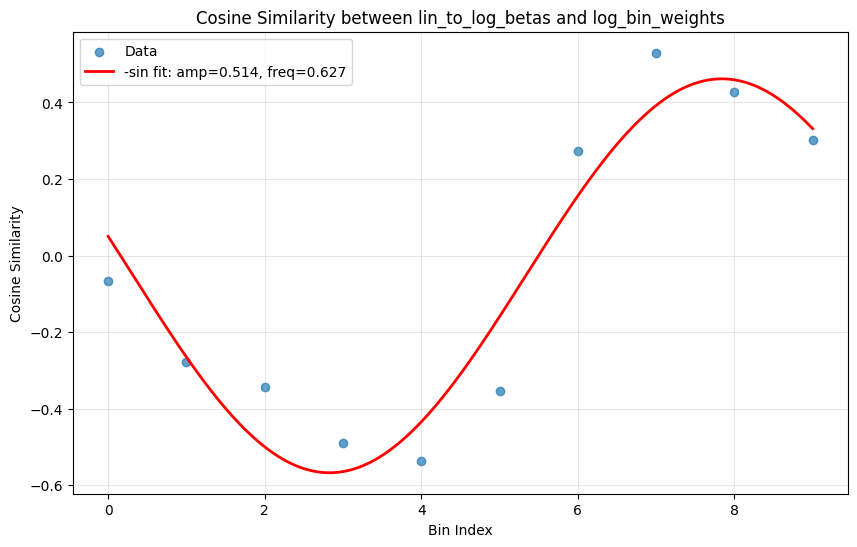

Fitted parameters:
Amplitude: 0.5145
Frequency: 0.6268
Phase: -0.2016
Offset: -0.0528


In [150]:
cosine_similarities = torch.cosine_similarity(lin_to_log_betas.float().unsqueeze(0), log_bin_weights.float(), dim=1)

# Fit -sin(x) to the cosine similarities
from scipy.optimize import curve_fit
import numpy as np

def neg_sin_func(x, amplitude, frequency, phase, offset):
    return -amplitude * np.sin(frequency * x + phase) + offset

x_data = np.arange(len(cosine_similarities))
y_data = cosine_similarities.detach().cpu().numpy()

# Initial guess for parameters: amplitude, frequency, phase, offset
initial_guess = [0.5, 2*np.pi/len(x_data), 0, np.mean(y_data)]

try:
    popt, _ = curve_fit(neg_sin_func, x_data, y_data, p0=initial_guess)
    amplitude, frequency, phase, offset = popt
    
    # Generate fitted curve
    x_fit = np.linspace(0, len(cosine_similarities)-1, 200)
    y_fit = neg_sin_func(x_fit, *popt)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(cosine_similarities)), y_data, alpha=0.7, label='Data')
    plt.plot(x_fit, y_fit, 'r-', linewidth=2, 
             label=f'-sin fit: amp={amplitude:.3f}, freq={frequency:.3f}')
    plt.xlabel('Bin Index')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity between lin_to_log_betas and log_bin_weights')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Fitted parameters:")
    print(f"Amplitude: {amplitude:.4f}")
    print(f"Frequency: {frequency:.4f}")
    print(f"Phase: {phase:.4f}")
    print(f"Offset: {offset:.4f}")
    
except Exception as e:
    print(f"Fitting failed: {e}")
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(cosine_similarities)), y_data)
    plt.xlabel('Bin Index')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity between lin_to_log_betas and log_bin_weights')
    plt.grid(True, alpha=0.3)
    plt.show()


In [155]:
# Get PCA of the model weights
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np

# Assuming we have the model weights in log_bin_weights
# log_bin_weights should be shape [n_bins, hidden_dim]
print(f"log_bin_weights shape: {log_bin_weights.shape}")

# Convert to numpy for PCA
weights_np = log_bin_weights.detach().cpu().numpy()

# Perform PCA
pca = PCA(n_components=3)
weights_pca = pca.fit_transform(weights_np)

print(f"PCA weights shape: {weights_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Also transform the betas to PCA space
lin_to_log_betas_np = lin_to_log_betas.float().detach().cpu().numpy()
betas_pca = pca.transform(lin_to_log_betas_np.reshape(1, -1))

# Create 3D scatter plot with Plotly
fig = go.Figure()

# Add scatter points for weights
fig.add_trace(go.Scatter3d(
    x=weights_pca[:, 0],
    y=weights_pca[:, 1],
    z=weights_pca[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color=np.arange(len(weights_pca)),
        colorscale='viridis',
        colorbar=dict(title="Bin Index"),
        showscale=True
    ),
    name='Model Weights',
    text=[f'Bin {i}' for i in range(len(weights_pca))],
    hovertemplate='<b>%{text}</b><br>PC1: %{x:.3f}<br>PC2: %{y:.3f}<br>PC3: %{z:.3f}<extra></extra>'
))

# Add arrow vector for betas (from origin to beta point)
fig.add_trace(go.Scatter3d(
    x=[0, betas_pca[0, 0]],
    y=[0, betas_pca[0, 1]],
    z=[0, betas_pca[0, 2]],
    mode='lines+markers',
    line=dict(color='red', width=8),
    marker=dict(size=[0, 10], color=['red', 'red']),
    name='lin_to_log_betas',
    hovertemplate='<b>Betas Vector</b><br>PC1: %{x:.3f}<br>PC2: %{y:.3f}<br>PC3: %{z:.3f}<extra></extra>'
))

# Add cone for arrow head
fig.add_trace(go.Cone(
    x=[betas_pca[0, 0]],
    y=[betas_pca[0, 1]],
    z=[betas_pca[0, 2]],
    u=[betas_pca[0, 0] * 0.1],
    v=[betas_pca[0, 1] * 0.1],
    w=[betas_pca[0, 2] * 0.1],
    colorscale='Reds',
    showscale=False,
    name='Beta Direction'
))

fig.update_layout(
    title='PCA of Model Weights with lin_to_log_betas Vector',
    scene=dict(
        xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]:.3f})',
        yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]:.3f})',
        zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]:.3f})',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    width=800,
    height=600
)

fig.show()

# Also create 2D projections with arrows
fig_2d = make_subplots(
    rows=1, cols=3,
    subplot_titles=['PC1 vs PC2', 'PC1 vs PC3', 'PC2 vs PC3'],
    specs=[[{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]]
)

# PC1 vs PC2
fig_2d.add_trace(go.Scatter(
    x=weights_pca[:, 0],
    y=weights_pca[:, 1],
    mode='markers',
    marker=dict(color=np.arange(len(weights_pca)), colorscale='viridis', size=8),
    name='Weights',
    showlegend=False
), row=1, col=1)

fig_2d.add_trace(go.Scatter(
    x=[0, betas_pca[0, 0]],
    y=[0, betas_pca[0, 1]],
    mode='lines+markers',
    line=dict(color='red', width=3),
    marker=dict(size=[0, 10], color='red'),
    name='Betas',
    showlegend=False
), row=1, col=1)

# PC1 vs PC3
fig_2d.add_trace(go.Scatter(
    x=weights_pca[:, 0],
    y=weights_pca[:, 2],
    mode='markers',
    marker=dict(color=np.arange(len(weights_pca)), colorscale='viridis', size=8),
    name='Weights',
    showlegend=False
), row=1, col=2)

fig_2d.add_trace(go.Scatter(
    x=[0, betas_pca[0, 0]],
    y=[0, betas_pca[0, 2]],
    mode='lines+markers',
    line=dict(color='red', width=3),
    marker=dict(size=[0, 10], color='red'),
    name='Betas',
    showlegend=False
), row=1, col=2)

# PC2 vs PC3
fig_2d.add_trace(go.Scatter(
    x=weights_pca[:, 1],
    y=weights_pca[:, 2],
    mode='markers',
    marker=dict(color=np.arange(len(weights_pca)), colorscale='viridis', size=8),
    name='Weights',
    showlegend=False
), row=1, col=3)

fig_2d.add_trace(go.Scatter(
    x=[0, betas_pca[0, 1]],
    y=[0, betas_pca[0, 2]],
    mode='lines+markers',
    line=dict(color='red', width=3),
    marker=dict(size=[0, 10], color='red'),
    name='Betas',
    showlegend=False
), row=1, col=3)

fig_2d.update_xaxes(title_text=f'PC1 ({pca.explained_variance_ratio_[0]:.3f})', row=1, col=1)
fig_2d.update_yaxes(title_text=f'PC2 ({pca.explained_variance_ratio_[1]:.3f})', row=1, col=1)
fig_2d.update_xaxes(title_text=f'PC1 ({pca.explained_variance_ratio_[0]:.3f})', row=1, col=2)
fig_2d.update_yaxes(title_text=f'PC3 ({pca.explained_variance_ratio_[2]:.3f})', row=1, col=2)
fig_2d.update_xaxes(title_text=f'PC2 ({pca.explained_variance_ratio_[1]:.3f})', row=1, col=3)
fig_2d.update_yaxes(title_text=f'PC3 ({pca.explained_variance_ratio_[2]:.3f})', row=1, col=3)

fig_2d.update_layout(
    title_text='2D PCA Projections with lin_to_log_betas Vectors',
    width=1200,
    height=400
)

fig_2d.show()


log_bin_weights shape: torch.Size([10, 2560])
PCA weights shape: (10, 3)
Explained variance ratio: [0.44155705 0.17454538 0.11676399]
Total explained variance: 0.7329


## 3. n_tokens before < / think>

## 4. R2 of predicted tokens with EMA = 0.9 and EMA = 0

show here that we do not benefit from more data

# 5. EMA of residual stream in 3-D with PCA. Try find rotation

In [4]:
lin_to_lin_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/linear_to_linear_betas.pt').to('cuda', dtype = torch.bfloat16)
lin_to_log_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/linear_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)
balanced_lin_to_lin_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/balanced_lin_to_lin_betas.pt').to('cuda', dtype = torch.bfloat16)
balanced_lin_to_log_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/balanced_lin_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)

In [5]:
def ema_residual_stream(activations: torch.Tensor, alpha: float) -> torch.Tensor:
    """
    Apply Exponential Moving Average (EMA) to the residual stream.
    
    Args:
        activations: Input tensor of shape (batch_size, sequence_length, hidden_dim)
        alpha: Smoothing factor (0 < alpha < 1)
        
    Returns:
        EMA of the residual stream
    """
    # Get the last hidden state from the activations    
    # Initialize the EMA of the residual stream
    ema_residual = torch.zeros_like(activations[0, 0, :]).to('cuda') # (d_model,)
    ema_values = torch.zeros_like(activations[0]).to('cuda') # (seq, d_model)
    
    # Apply EMA to the residual stream looking backwards
    for i in range(activations.shape[1]):
        ema_residual = alpha * activations[0, i, :] + (1 - alpha) * ema_residual
        ema_values[i] = ema_residual
        ema_residual = ema_residual.detach()
    return ema_values

# Apply EMA to the residual stream



In [180]:
ema_sequences = []
for i in range(100):
    token_ids, sequence = torch.load(f'/workspace/llm-progress-monitor/rollouts-big/test/activations/{i}.pt')
    sequence = sequence.to('cuda')
    start_pos = get_start_pos(token_ids)
    sequence = sequence[:, start_pos:]
    actual_n_remaining = sequence.shape[1] - torch.arange(sequence.shape[1], device=sequence.device)
    ema_sequence = ema_residual_stream(sequence, 0.99)
    ema_sequences.append(ema_sequence)

In [182]:
# Concatenate all EMA sequences for PCA
all_ema_data = torch.cat(ema_sequences, dim=0).float()  # Shape: (total_tokens, d_model)

# Center the data
mean_ema = torch.mean(all_ema_data, dim=0, keepdim=True)
centered_ema_data = all_ema_data - mean_ema

# Compute PCA using SVD
U, S, V = torch.svd(centered_ema_data)

# Get the first 2 principal components
pca_directions = V[:, :2]  # Shape: (d_model, 2) - first 2 principal component directions
explained_variance = S[:2]**2 / (all_ema_data.shape[0] - 1)  # Explained variance for first 2 components

print(f"Shape of first 2 PCA directions: {pca_directions.shape}")
print(f"Explained variance of first 2 components: {explained_variance}")
print(f"Explained variance ratio of first 2 components: {torch.sum(explained_variance) / torch.sum(S**2 / (all_ema_data.shape[0] - 1)):.4f}")



Shape of first 2 PCA directions: torch.Size([2560, 2])
Explained variance of first 2 components: tensor([47.2158, 29.1235], device='cuda:0')
Explained variance ratio of first 2 components: 0.0608


In [188]:
# Get the linear layer weights
weights = model.linear.weight.float()  # Shape: (vocab_size, d_model)

# Center the weights
mean_weights = torch.mean(weights, dim=0, keepdim=True)
centered_weights = weights - mean_weights

# Compute PCA using SVD
U_weights, S_weights, V_weights = torch.svd(centered_weights)

# Get the first 2 principal components
pca_directions_weights = V_weights[:, :2]  # Shape: (d_model, 2)
explained_variance_weights = S_weights[:2]**2 / (weights.shape[0] - 1)

print(f"Shape of first 2 PCA directions for weights: {pca_directions_weights.shape}")
print(f"Explained variance of first 2 components for weights: {explained_variance_weights}")
print(f"Explained variance ratio of first 2 components for weights: {torch.sum(explained_variance_weights) / torch.sum(S_weights**2 / (weights.shape[0] - 1)):.4f}")

Shape of first 2 PCA directions for weights: torch.Size([2560, 2])
Explained variance of first 2 components for weights: tensor([0.6299, 0.2490], device='cuda:0', grad_fn=<DivBackward0>)
Explained variance ratio of first 2 components for weights: 0.6161


In [203]:
# Project each EMA sequence onto the first 2 principal components
projected_sequences = []

for ema_sequence in ema_sequences:
    # Center the sequence using the same mean as the PCA
    centered_sequence = ema_sequence.float() - mean_ema
    
    # Project onto the first 2 principal components
    projected_sequence = torch.matmul(centered_sequence, pca_directions_weights)  # Shape: (seq_len, 2)
    projected_sequences.append(projected_sequence)

print(f"Number of projected sequences: {len(projected_sequences)}")
print(f"Shape of first projected sequence: {projected_sequences[0].shape}")


Number of projected sequences: 100
Shape of first projected sequence: torch.Size([1173, 2])


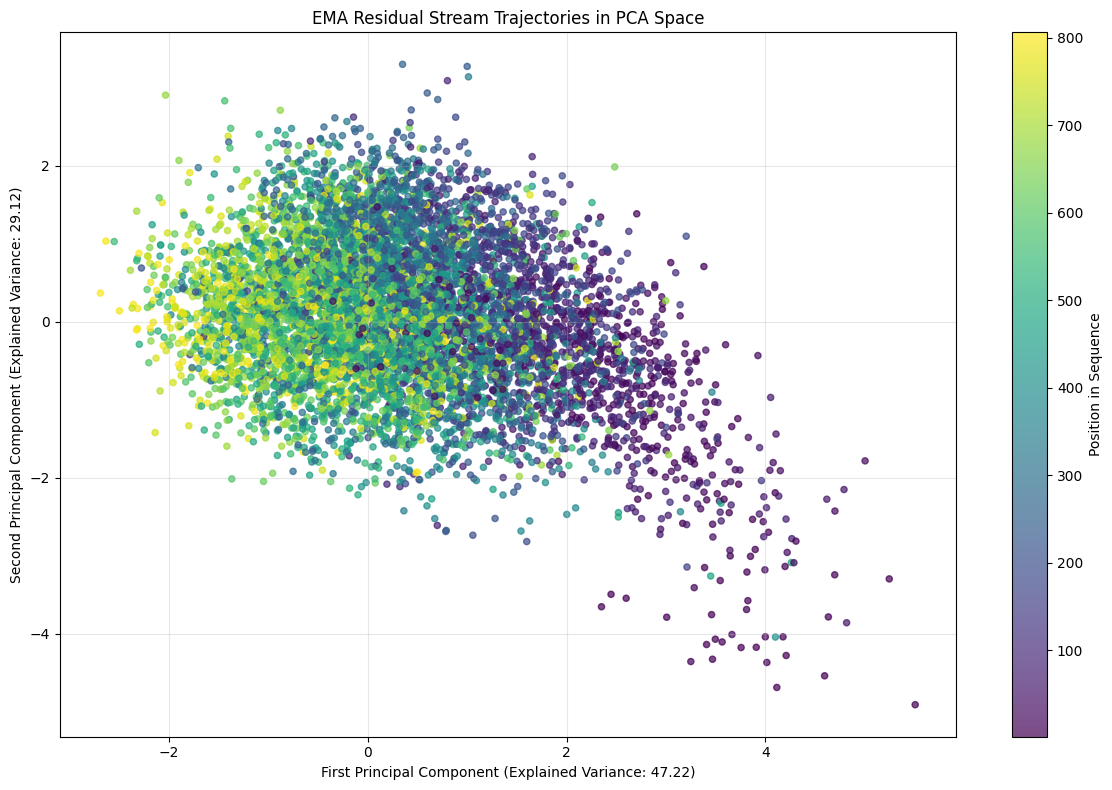

In [206]:
# Plot all projected sequences on the same 2D axis
plt.figure(figsize=(12, 8))

# Plot each projected sequence
for i, projected_seq in enumerate(projected_sequences[:10]):
    projected_seq_cpu = projected_seq.detach().cpu().numpy()
    # Color by the number remaining in sequence (sequence length decreases over time)
    colors = range(len(projected_seq_cpu),0,-1)
    scatter = plt.scatter(projected_seq_cpu[:, 0], projected_seq_cpu[:, 1], 
                         c=colors, cmap='viridis', alpha=0.7, s=20, label=f'Sequence {i+1}')

plt.xlabel(f'First Principal Component (Explained Variance: {explained_variance[0]:.2f})')
plt.ylabel(f'Second Principal Component (Explained Variance: {explained_variance[1]:.2f})')
plt.title('EMA Residual Stream Trajectories in PCA Space')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Position in Sequence')
plt.tight_layout()
plt.show()


In [8]:
def bin_y(y):
    return (y+1).log().floor().clamp(0,n_bins-1).to('cuda', dtype=torch.long)

In [ ]:
bin_averages = {}
for i in range(100):
    token_ids, sequence = torch.load(f'/workspace/llm-progress-monitor/rollouts-big/test/activations/{i}.pt')
    sequence = sequence.to('cuda')
    start_idx = get_start_pos(token_ids)
    sequence = sequence[start_idx:]
    actual_n_remaining = sequence.shape[1] - torch.arange(sequence.shape[1], device=sequence.device)
    binned_n_remaining = bin_y(actual_n_remaining)
    
    # Group by bins and compute averages
    for bin_idx in torch.unique(binned_n_remaining):
        bin_mask = binned_n_remaining == bin_idx
        bin_activations = sequence[0, bin_mask, :]  # Shape: (n_positions_in_bin, 2560)
        bin_average = bin_activations.mean(dim=0)  # Shape: (2560,)
        
        if bin_idx.item() not in bin_averages:
            bin_averages[bin_idx.item()] = []
        bin_averages[bin_idx.item()].append(bin_average)

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [19]:
actual_bin_averages = {}

In [20]:
for bin_idx, data in bin_averages.items():
    actual_bin_averages[bin_idx] = torch.stack(data,dim=0).mean(dim=0)

In [26]:
import matplotlib.pyplot as plt

torch.Size([8, 2560])


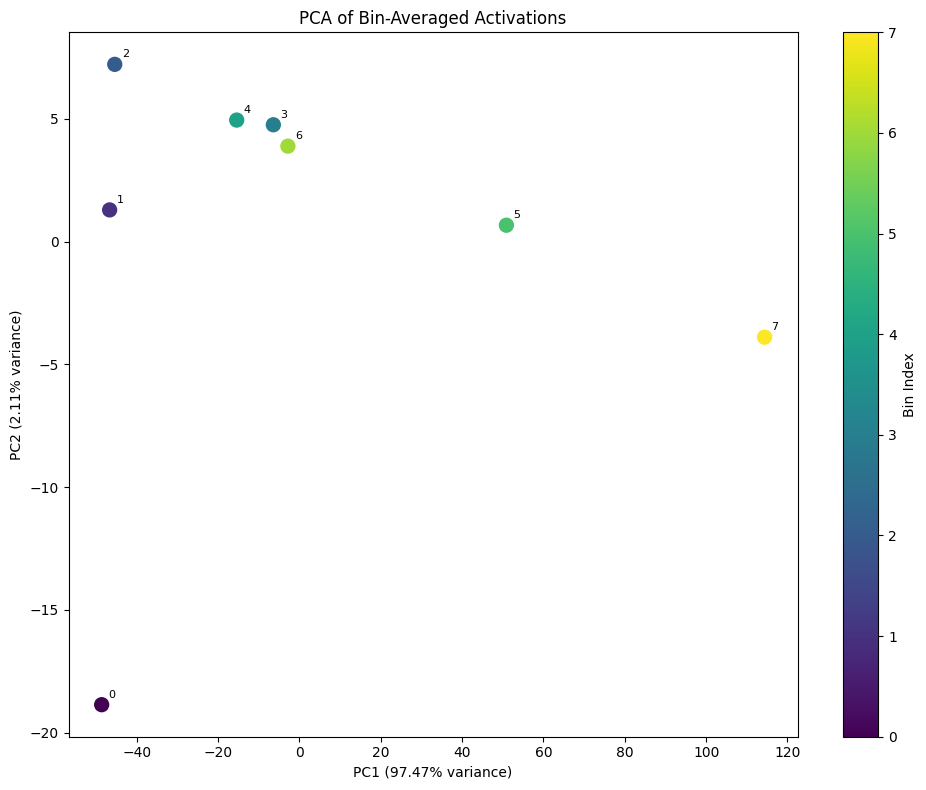

In [27]:
# Stack the bin averages and compute PCA
bin_data = torch.stack(list(actual_bin_averages.values()), dim=0).float()
print(bin_data.shape)

# Convert to numpy for sklearn PCA
bin_data_np = bin_data.cpu().numpy()

# Compute PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(bin_data_np)

# Plot the PCA results
plt.figure(figsize=(10, 8))
bin_indices = list(actual_bin_averages.keys())
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=bin_indices, cmap='viridis', s=100)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA of Bin-Averaged Activations')
plt.colorbar(scatter, label='Bin Index')

# Add text labels for each point
for i, bin_idx in enumerate(bin_indices):
    plt.annotate(f'{bin_idx}', (pca_result[i, 0], pca_result[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()